In [1]:
from pathlib import Path
import time
import logging
import random

import numpy as np
import torch
from torch import nn, optim
from pytorch_pretrained_bert.optimization import BertAdam
from torch.utils.data import DataLoader
import torch.nn.functional as F

from scipy.stats import pearsonr
import matplotlib.pyplot as plt

import sys
sys.path.append(r'C:\Python\projects\PyLT3')

from pylt3.ml.rnn.LazyTextDataset import LazyTextDataset

Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.


[INFO] 2019-04-05 14:13:57,719: 'pattern' package found; tag filters are available for English


In [2]:
# Make results reproducible
random.seed(3)
torch.manual_seed(3)
torch.backends.cudnn.deterministic = True
np.random.seed(3)

# run all numpy warnings as errors:
np.seterr(all='raise')

logging.basicConfig(format='[%(levelno)s] %(asctime)s: %(message)s', datefmt='%d-%b-%y %H:%M:%S')

In [3]:
# Word2Vec and/or ELMo and/or BERT initialisation
use_ms = False

use_google_w2v = False
use_custom_w2v = False
use_elmo = False
use_bert = True

In [4]:
if use_ms:
    from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

if len(list(filter(None, (use_google_w2v, use_custom_w2v)))) > 1:
    raise ValueError(f"Only one of 'use_google_w2v' or 'use_custom_w2v' can be used.")
else:
    use_w2v = any((use_google_w2v, use_custom_w2v))
    if use_w2v:
        import gensim
        if use_google_w2v:
            embed_p = Path(r'C:\Users\Bram\Downloads\GoogleNews-vectors-negative300.bin').resolve()
            w2v_model = gensim.models.KeyedVectors.load_word2vec_format(str(embed_p), binary=True)
            # add a padding token with only zeros
            # TODO: find alternative for unknown tokens. Zeros is NOT a good idea
            w2v_model.add(['@pad@', '@unk@'], [np.zeros(w2v_model.vectors.shape[1]), np.zeros(w2v_model.vectors.shape[1])])
        elif use_custom_w2v:
            embed_p = Path('..\..\..\data\dpc\ml\other\dpc+news2017.dim146-ep10-min2-win10-repl.w2v_model').resolve()
            w2v_model = gensim.models.KeyedVectors.load_word2vec_format(str(embed_p))
            # add a padding token with only zeros
            w2v_model.add(['@pad@'], [np.zeros(w2v_model.vectors.shape[1])])
            
        w2v_config = {
            'model': w2v_model,
            'weights': torch.FloatTensor(w2v_model.vectors)
        }
    else:
        w2v_config = None
        
if use_elmo:
    from allennlp.modules.elmo import Elmo, batch_to_ids
    elmo_config = {
        'options_url': 'https://s3-us-west-2.amazonaws.com/allennlp/models/elmo/2x4096_512_2048cnn_2xhighway/elmo_2x4096_512_2048cnn_2xhighway_options.json',
        'weights_url': 'https://s3-us-west-2.amazonaws.com/allennlp/models/elmo/2x4096_512_2048cnn_2xhighway/elmo_2x4096_512_2048cnn_2xhighway_weights.hdf5'
    }
else:
    elmo_config = None
    
if use_bert:
    from pytorch_pretrained_bert.tokenization import BertTokenizer
    from pytorch_pretrained_bert.modeling import BertModel
    # For OOM errors, see https://github.com/google-research/bert/blob/master/README.md#out-of-memory-issues
    # Comes down to: lower max_seq_len and batch_size
    bert_config = {
        'tokenizer': BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True),
        'model_str': 'bert-base-uncased',
        'layers': '-1,-2,-3,-4',
        'max_seq_len': 64
    }
else:
    bert_config = None

[INFO] 2019-04-05 14:13:58,677: loading vocabulary file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at C:\Users\Bram\.pytorch_pretrained_bert\26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084


In [5]:
class Regressor(nn.Module):
    def __init__(self, hidden_dim=512, ms_dim=None, w2v=None, elmo=None, bert=None, bidirectional=True, drop_prob=0):
        super(Regressor, self).__init__()
        self.hidden_dim = hidden_dim
        self.ms_dim = ms_dim
        self.w2v = w2v
        self.elmo = elmo
        self.bert = bert
        self.bidirectional = bidirectional
        self.drop_prob = drop_prob
        
        input_fc = 0
        
        if ms_dim is not None:
            self.ms_rnode = nn.GRU(ms_dim, hidden_dim, bidirectional=bidirectional, batch_first=True)
            input_fc += hidden_dim
            logging.info('Morphosyntactic features enabled...')
            
        if w2v is not None:
            self.w2v = nn.Embedding.from_pretrained(w2v['weights'], freeze=True)        
            self.w2v_rnode = nn.GRU(w2v['weights'].size(1), hidden_dim, bidirectional=bidirectional, batch_first=True)
            input_fc += hidden_dim
            logging.info('Word embeddings enabled...')
        
        if elmo is not None:
            self.elmo = Elmo(elmo['options_url'], elmo['weights_url'], 1, dropout=drop_prob)
#             self.elmo_rnode = nn.GRU(1024, hidden_dim, bidirectional=bidirectional)
#             input_fc += hidden_dim
            input_fc += 1024
            logging.info('ELMo enabled...')
            
        if bert is not None:
            self.bert = BertModel.from_pretrained(bert['model_str'])
            # Freeze embeddings
            for name, param in self.bert.named_parameters():                
                if name.startswith('embeddings'):
                    param.requires_grad = False
            
            self.bert_max_seq_len = bert['max_seq_len']
            self.bert_layers = [int(l) for l in bert['layers'].split(',')]
#             input_fc += 768 * len(self.bert_layers)
            self.linear_bert = nn.Linear(768 * len(self.bert_layers), hidden_dim)
            input_fc += hidden_dim
            logging.info('Bert enabled...')
        
        self.dropout = nn.Dropout(drop_prob) if drop_prob > 0 else None
        self.linear = nn.Linear(input_fc, 1)
        self.lrelu = nn.LeakyReLU(negative_slope=0.0000001)
        
    def _last_output(self, output, bidirectional=None):
        bidirectional = self.bidirectional if bidirectional is None else bidirectional
        if bidirectional:
            sum_bi = output[:, :, :self.hidden_dim] + output[:, :, self.hidden_dim:]
            last = sum_bi[:, -1, :]
        else:
            last = output[:, -1, :]
    
        return last    
    
    def forward(self, batch_size, ms_input=None, w2v_ids=None, elmo_ids=None, bert_input=None):      
        if self.ms_dim is not None and ms_input is not None:
            packed_ms_out, _ = self.ms_rnode(ms_input)
#             print('packed ms output', packed_ms_out.data.size())            
            # unpacked
            unpacked_ms_out, ms_lengths = pad_packed_sequence(packed_ms_out, batch_first=True)
#             print('unpacked ms input', unpacked_ms_out.size())
            
            if self.bidirectional:
                # Sum two bidirectional layers
                unpacked_ms_out = unpacked_ms_out[:, :, :self.hidden_dim] + unpacked_ms_out[:, :, self.hidden_dim:]
#                 print('summed ms input', unpacked_ms_out.size())
            # Get last item of each sequence, based on their *actual* lengths
            final_ms = unpacked_ms_out[torch.arange(len(ms_lengths)), ms_lengths-1, :]
#             print('final ms input', final_ms.size())
        else:
            final_ms = None
        
        if self.w2v is not None and w2v_ids is not None:            
#             print('w2v_ids', w2v_ids.size())
            w2v_out = self.w2v(w2v_ids)            
#             print('w2v_out', w2v_out.size())
            w2v_out, _ = self.w2v_rnode(w2v_out)
            final_w2v = self._last_output(w2v_out)
#             print('last w2v', final_w2v.size())
        else:
            final_w2v = None         
                
        if self.elmo is not None and elmo_ids is not None:
            elmo_out = self.elmo(elmo_ids)
            elmo_out = elmo_out['elmo_representations'][0]
#             print('elmo representation size', elmo_out.size())
#             elmo_out, _ = self.elmo_rnode(elmo_out)
            
#             final_elmo = self._last_output(elmo_out)
            final_elmo = elmo_out[:, -1, :]
#             print('last elmo', final_elmo.size())
        else:
            final_elmo = None
        
        if self.bert is not None and bert_input is not None:
            bert_ids, bert_mask = bert_input
            all_bert_layers, _ = self.bert(bert_ids, attention_mask=bert_mask)
            bert_concat = torch.cat([all_bert_layers[i] for i in self.bert_layers], dim=-1)
            # Pooling by also setting masked items to zero
            bert_mask = bert_mask.to(torch.float).unsqueeze(2)
            # Multiply output with mask 
            bert_pooled = bert_concat * bert_mask
            
#             print('bert pooled', bert_pooled.size())
            
            # First item ['CLS'] should be sentence representation
            final_bert = bert_pooled[:, 0, :]
            final_bert = self.linear_bert(final_bert)
            
            # FOR AVERAGING instead of taking CLS node
            """
            # Sum items in sequence to get sentence representation
            bert_summed = torch.sum(bert_pooled, dim=1).squeeze()
            # Average over seq_length
            final_bert = torch.div(bert_summed, self.bert_max_seq_len)
            """          
            
#             print('final bert', final_bert.size())
        else:
            final_bert = None  
        
        sentence_finals = [final for final in [final_w2v, final_elmo, final_bert] if final is not None]
        
        # Sentence features concatenate
        if len(sentence_finals) > 1:
            sentence_cat = torch.cat(sentence_finals, dim=1)
        elif len(sentence_finals) == 1:
            sentence_cat = sentence_finals[0]
        else:
            sentence_cat = None
        
        if sentence_cat is not None:
#             print('sentence_cat', sentence_cat.size())
            pass

        # Concatenating    
        if final_ms is not None and sentence_cat is not None:
            sentence_ms_cat = torch.cat((sentence_cat, final_ms), dim=1)
        elif final_ms is not None:
            sentence_ms_cat = final_ms
        elif sentence_cat is not None:
            sentence_ms_cat = sentence_cat
        
#         print('sentence_ms_cat', sentence_ms_cat.size())
            
        # Only use the last item's output
        if self.drop_prob > 0:
            sentence_ms_cat = self.dropout(sentence_ms_cat)
        
        regression = self.linear(sentence_ms_cat)
        regression = self.lrelu(regression)
        
#         print('regression', regression.size())

        return regression

In [6]:
class RegressionRNN:
    def __init__(self, train_files=None, valid_files=None, test_files=None, ms_dim=None, use_w2v=False,
                 use_elmo=False, bert=None, batch_size=(64, 64)):
        print('Using torch ' + torch.__version__)

        self.datasets, self.dataloaders = RegressionRNN._set_data_loaders(train_files, valid_files, test_files, batch_size)
        self.device = RegressionRNN._set_device()
        
        self.use_ms = True if ms_dim is not None else False
        self.ms_dim = ms_dim
        self.use_w2v = use_w2v
        self.use_elmo = use_elmo
        
        self.use_bert = True if bert is not None else False
        self.bert_tokenizer = bert_config['tokenizer'] if bert is not None else None
        self.bert_max_seq_len = bert_config['max_seq_len'] if bert else None
        
        self.use_sentences = any((use_w2v, use_elmo, self.use_bert))
        
        if len(list(filter(None, [self.use_ms, self.use_sentences]))) + 1 != len(train_files):
            logging.warning('The number of input files is not the same as the number of enabled features.'
                            ' Be warned!')
        
        self.model = None
        self.w2v_vocab = None
        self.criterion = None
        self.optimizer = None
        self.bert_optimizer = None
        self.scheduler = None
        self.checkpoint_f = None

    @staticmethod
    def _set_data_loaders(train_files, valid_files, test_files, batch_size):
        RegressionRNN._verify_input(train_files, valid_files, test_files)

        datasets = {
            'train': LazyTextDataset(train_files) if train_files is not None else None,
            'valid': LazyTextDataset(valid_files) if valid_files is not None else None,
            'test': LazyTextDataset(test_files) if test_files is not None else None
        }
        
        logging.info(f"Training set size: {len(datasets['train'])}")
        
        if valid_files:
            logging.info(f"Validation set size: {len(datasets['valid'])}")
        if test_files:
            logging.info(f"Test set size: {len(datasets['test'])}")                     

        dataloaders = {
            'train': DataLoader(datasets['train'], batch_size=batch_size[0], shuffle=True, num_workers=6) if train_files is not None else None,
            'valid': DataLoader(datasets['valid'], batch_size=batch_size[1], shuffle=True, num_workers=6) if valid_files is not None else None,
            'test': DataLoader(datasets['test'], batch_size=batch_size[1], shuffle=True, num_workers=6) if test_files is not None else None
        }

        return datasets, dataloaders

    @staticmethod
    def _set_device():
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        if device.type == 'cuda':
            device_id = torch.cuda.current_device()
            logging.info(f"Using GPU {torch.cuda.get_device_name(device_id)}")
            # logging.info('Memory Usage:')
            # logging.info('Allocated:', round(torch.cuda.memory_allocated(device_id) / 1024 ** 3, 1), 'GB')
            # logging.info('Cached:   ', round(torch.cuda.memory_cached(device_id) / 1024 ** 3, 1), 'GB')
        else:
            logging.info('Using CPU...')

        return device

    @staticmethod
    def _verify_input(train_files, test_files, valid_files):
        for f_kind in [train_files, test_files, valid_files]:
            if f_kind is None:
                continue

            for f in f_kind:
                if not Path(f).resolve().is_file():
                    raise ValueError(f"Input file {str(f)} does not exist.")  
    
    @staticmethod
    def prepare_lines(data, split_on=None, cast_to=None):
        out = []
        for line in data:
            line = line.strip()
            if split_on:
                line = line.split(split_on)
                line = list(filter(None, line))
            else:
                line = [line] 

            if cast_to is not None:
                line = [cast_to(l) for l in line]
                
            out.append(line)

        return out
    
    def prepare_ms(self, data):
        def pad_array(data, max_size):
            """ Pad all 'sentences' to the size of the largest sentence. """
            # number of features in deepest list
            feature_size = len(data[0][0])

            for idx, arr in enumerate(data):
                # If the list is smaller than the largest list -> pad it
                if len(arr) < max_size:
                    # Create a new zero-only array
                    pad = np.zeros((max_size, feature_size), dtype=np.int8)
                    # Replace the first part with the actual list
                    pad[:len(arr)] = arr
                    # Replace in-place in the top-level list
                    data[idx] = pad

            return np.array(data).reshape(-1, max_size, feature_size)

        seqs = []
        # Data is a 'text' of 'sentences'
        for line in data:
            # Every line is a 'sentence' of tab-separated 'tokens' 
            line = line.strip()
            # Every token is a 'word' which is a list of 0s and 1s
            tokens = line.split('\t')
            tokens = [list((map(int, token.split(' ')))) for token in tokens]            
            seqs.append(np.array(tokens))      
                         
        
        # Get the length of the not-padded sequences
        lengths = torch.LongTensor([len(s) for s in seqs])
        
        # Create zero-only dataset                 
        seq_tensor = torch.zeros(len(seqs), lengths.max(), self.ms_dim)
        
        # Fill in real values                 
        for idx, (seq, seqlen) in enumerate(zip(seqs, lengths)):
            seq_tensor[idx, :seqlen] = torch.FloatTensor(seq)              

        # Gets back sorted lengths and the indices of sorted items
        lengths, sorted_idxs = torch.sort(lengths, dim=0, descending=True)
        # Sort tensor by using sorted indices
#         print(sorted_idxs)
        seq_tensor = seq_tensor[sorted_idxs, :, :]
        # Pack sequences
        packed_seqs = pack_padded_sequence(seq_tensor, lengths, batch_first=True)
        
        return packed_seqs, sorted_idxs
                         
    def prepare_w2v(self, data):
        """ Gets the word2vec ID of the tokens.
            Input is a batch of sentences, consisting of tokens. """
        idxs = []
        # Get size of longest sequence
        max_length = max([len(seq) for seq in data])

        for seq in data:
            tok_idxs = []
            for word in seq:
                try:
                    tok_idxs.append(self.w2v_vocab[word].index)
                except KeyError:
                    tok_idxs.append(self.w2v_vocab['@unk@'].index)
            
            # Pad current sequence if smaller than largest sequence
            seq_length = len(seq)
            if seq_length < max_length:
                tok_idxs.extend([self.w2v_vocab['@pad@'].index] * (max_length - seq_length))

            idxs.append(tok_idxs)
        
        idxs = torch.LongTensor(idxs)
        return idxs   
                                 
    @staticmethod
    def prepare_elmo(sentences):
        # Add <S> and </S> tokens to sentence
        # See https://github.com/allenai/allennlp/blob/master/tutorials/how_to/elmo.md#notes-on-statefulness-and-non-determinism        
        elmo_sentences = []
        for s in sentences:
            elmo_sentences.append(['<S>', *s, '</S>'])
        
        return elmo_sentences
    
    def prepare_bert(self, sentences):
        all_input_ids = []
        all_input_mask = []
        for sentence in sentences:
            sentence = ' '.join(sentence)
            # tokenizer will also separate on punctuation
            # see https://github.com/google-research/bert#tokenization
            tokens = self.bert_tokenizer.tokenize(sentence)

            # limit size of tokens
            if len(tokens) > self.bert_max_seq_len - 2:
                tokens = tokens[0:(self.bert_max_seq_len - 2)]

            # add [CLS] and [SEP], as expected in BERT
            tokens = ['[CLS]', *tokens, '[SEP]']

            input_type_ids = [0] * len(tokens)
            input_ids = self.bert_tokenizer.convert_tokens_to_ids(tokens)

            # The mask has 1 for real tokens and 0 for padding tokens. Only real
            # tokens are attended to.
            input_mask = [1] * len(input_ids)

            # Zero-pad up to the sequence length.
            while len(input_ids) < self.bert_max_seq_len:
                input_ids.append(0)
                input_mask.append(0)

            all_input_ids.append(input_ids)
            all_input_mask.append(input_mask)
        
        all_input_ids = torch.LongTensor(all_input_ids)
        all_input_mask = torch.LongTensor(all_input_mask)
                         
        return all_input_ids, all_input_mask                             
                         
    @staticmethod
    def _plot_training(train_losses, valid_losses):
        plt.subplot(1, 2, 1)
        plt.plot(train_losses, label='Training loss')
        plt.plot(valid_losses, label='Validation loss')
        plt.xlabel('epochs')
        plt.legend(frameon=False)
        plt.title('Loss progress')

        plt.show()
        plt.savefig('progress.png')
                
    def train(self, epochs=10, checkpoint_f='checkpoint.pth', log_update_freq=0, patience=None):
        logging.info('Training started.')        
        train_start = time.time()
        
        self.checkpoint_f = checkpoint_f

        valid_loss_min = np.inf
        train_losses, valid_losses = [], []
        last_saved_epoch = 0
        # keep
        total_train_time = 0
        for epoch in range(epochs):
            epoch_start = time.time()
            
            train_loss, train_results = self._process('train', log_update_freq, epoch)
            total_train_time += time.time() - epoch_start
            
            valid_loss, valid_results = self._process('valid', log_update_freq, epoch)
            
            try:
                train_pearson = pearsonr(train_results['predictions'], train_results['targets'])
            except FloatingPointError:
                train_pearson = "Could not calculate Pearsonr"
            
            try:
                valid_pearson = pearsonr(valid_results['predictions'], valid_results['targets'])
            except FloatingPointError:
                valid_pearson = "Could not calculate Pearsonr"
            
            # calculate average losses
            train_loss = np.mean(train_loss)
            valid_loss = np.mean(valid_loss)
            
            train_losses.append(train_loss)
            valid_losses.append(valid_loss)
            
            # print training/validation statistics            
            logging.info(f"Epoch {epoch} - completed in {(time.time() - epoch_start):.0f} seconds\n"
                         f"Training Loss: {train_loss:.6f}\t Pearson: {train_pearson}\n"
                         f"Validation loss: {valid_loss:.6f}\t Pearson: {valid_pearson}")
            
            # save model if validation loss has decreased
            if valid_loss <= valid_loss_min:
                logging.info(f'!! Validation loss decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}).')
                logging.info(f'!! Saving model as {self.checkpoint_f}...')
                
                torch.save(self.model.state_dict(), self.checkpoint_f)
                last_saved_epoch = epoch                         
                valid_loss_min = valid_loss
            else:
                logging.info(f"!! Valid loss not improved. (Min. = {valid_loss_min}; last save at ep. {last_saved_epoch})")
                if train_loss <= valid_loss:
                    logging.warning(f"!! Training loss is lte validation loss. Might be overfitting!")
            
            # Early-stopping
            if patience is not None:
                if (epoch - last_saved_epoch) == patience:
                    logging.info(f"Stopping early at epoch {epoch} (patience={patience})...")
                    break
            
            # Optimise with scheduler
            if self.scheduler is not None:
                self.scheduler.step(valid_loss)
            
        RegressionRNN._plot_training(train_losses, valid_losses)
        
        logging.info(f"Training completed in {(time.time() - train_start):.0f} seconds"
                     f"\nMin. valid loss: {valid_loss_min}\nLast saved epoch: {last_saved_epoch}"
                     f"\nPerformance: {len(self.datasets['train'])//total_train_time:.0f} sentences/s")

    def _process(self, do, log_update_freq, epoch=None):
        if do not in ('train', 'valid', 'test'):
            raise ValueError("Use 'train', 'valid', or 'test' for 'do'.")
        
        results = {'predictions': np.array([]), 'targets': np.array([])}
        losses = np.array([])

        self.model = self.model.to(self.device)
        if do == 'train':
            self.model.train()            
            torch.set_grad_enabled(True)
        else:
            self.model.eval()
            torch.set_grad_enabled(False)
        
        if log_update_freq:
            nro_batches = len(self.datasets[do]) // self.dataloaders[do].batch_size
            update_interval = nro_batches * (log_update_freq/100)
            update_checkpoints = {int(nro_batches-(i*update_interval)) for i in range((100//log_update_freq))}
        
        for batch_idx, data in enumerate(self.dataloaders[do], 1):
            # 0. Clear gradients
            if do == 'train':                
                self.optimizer.zero_grad()
                if self.use_bert and self.bert_optimizer is not None:
                    self.bert_optimizer.zero_grad()                     
                
            # 1. Data prep
            if self.use_ms:
                ms = data[0]
                if self.use_sentences:
                    sentence = data[1]
            elif self.use_sentences:
                sentence = data[0]
                     
            target = data[-1]
                     
            # Convert ms features to int array
            if self.use_ms: 
                ms, sorted_ids = self.prepare_ms(ms)
                ms = ms.to(self.device)
            else:
                ms = None
            
            # Convert sentence to token array
            if self.use_sentences:
                sentence = self.prepare_lines(sentence, split_on=' ')
            
            # Convert tokens to word2vec IDs
            if self.use_w2v:
                w2v_ids = self.prepare_w2v(sentence)
                w2v_ids = w2v_ids[sorted_ids] if ms is not None else w2v_ids
                w2v_ids = w2v_ids.to(self.device)
            else:
                w2v_ids = None   
            
            if self.use_elmo:
                elmo_sentence = RegressionRNN.prepare_elmo(sentence)
                elmo_ids = batch_to_ids(elmo_sentence)                     
                elmo_ids = elmo_ids[sorted_ids] if self.use_ms else elmo_ids
                elmo_ids = elmo_ids.to(self.device)
            else:
                elmo_ids = None
            
            if self.use_bert:
                bert_ids, bert_mask = self.prepare_bert(sentence)                     
                bert_ids = bert_ids[sorted_ids] if self.use_ms else bert_ids
                bert_mask = bert_mask[sorted_ids] if self.use_ms else bert_mask
                     
                bert_ids = bert_ids.to(self.device)
                bert_mask = bert_mask.to(self.device)
                bert_input = (bert_ids, bert_mask)
            else:
                bert_input = None
            
            # Convert target to float array
            target = torch.Tensor(self.prepare_lines(target, cast_to=float))
            target = target[sorted_ids] if self.use_ms else target
            # Get current batch size
            curr_batch_size = target.size(0)           
                     
            target = target.to(self.device)   

            # 2. Predictions
            pred = self.model(curr_batch_size, ms, w2v_ids, elmo_ids, bert_input)
            loss = self.criterion(pred, target)
                    
            # 3. Optimise during training
            if do == 'train':
                loss.backward()
                self.optimizer.step()
                if self.use_bert and self.bert_optimizer is not None:
                    self.bert_optimizer.step()
            
            # 4. Save results
            pred = pred.detach().cpu().numpy()
            target = target.cpu().numpy()
            
            results['predictions'] = np.append(results['predictions'], pred, axis=None)            
            results['targets'] = np.append(results['targets'], target, axis=None)
            losses = np.append(losses, float(loss))

            if log_update_freq and batch_idx in update_checkpoints:
                if do in ('train', 'valid'):
                    logging.info(f"{do.capitalize()} epoch {epoch}, batch nr. {batch_idx}/{nro_batches}...")
                else:                        
                    logging.info(f"{do.capitalize()}, batch nr. {batch_idx}/{nro_batches}...")
        
        torch.set_grad_enabled(True)

        return losses, results

    def test(self, checkpoint_f='checkpoint.pth', log_update_freq=0):
        logging.info('Testing started.')
        test_start = time.time()
        
        if self.checkpoint_f is None:
            self.model.load_state_dict(torch.load(checkpoint_f, map_location=self.device))
        else:
            self.model.load_state_dict(torch.load(self.checkpoint_f, map_location=self.device))

        test_loss, test_results = self._process('test', log_update_freq)

        try:
            test_pearson = pearsonr(test_results['predictions'], test_results['targets'])
        except FloatingPointError:
            test_pearson = "Could not calculate Pearsonr"
        
        test_loss = np.mean(test_loss)
        
        logging.info(f"Testing completed in {(time.time() - test_start):.0f} seconds"
                     f"\nLoss: {test_loss:.6f}\t Pearson: {test_pearson}\n")

In [7]:
HIDDEN_DIM = 512
MS_SIZE = 102 if use_ms else None

files = {
    'train_files': (r'C:\wsl-shared\cross-conll\train\dpc.tok.norm.clean.cut.en.train',                                  
                    r'C:\wsl-shared\cross-conll\train\cross.txt'),
     'valid_files': (r'C:\wsl-shared\cross-conll\dev\dpc.tok.norm.clean.cut.en.dev',
                     r'C:\wsl-shared\cross-conll\dev\cross.txt'),
     'test_files': (r'C:\wsl-shared\cross-conll\test\dpc.tok.norm.clean.cut.en.test',                                 
                    r'C:\wsl-shared\cross-conll\test\cross.txt'),
}

regr = RegressionRNN(**files,
                     ms_dim = MS_SIZE,
                     use_w2v=use_w2v,
                     use_elmo=use_elmo,
                     bert=bert_config,
                     batch_size=(64, 64))

if use_w2v:
    regr.w2v_vocab = w2v_config['model'].vocab        

regr.model = Regressor(HIDDEN_DIM, 
                       ms_dim=MS_SIZE, 
                       w2v=w2v_config,
                       elmo=elmo_config,
                       bert=bert_config,
                       bidirectional=True,
                       drop_prob=0)

regr.criterion = nn.MSELoss()
regr.optimizer = BertAdam([p for p in regr.model.parameters() if p.requires_grad],
                          lr=0.00002,
                          weight_decay=0.0002)


# regr.optimizer = optim.Adam([
#     {'params': [p for name, p in regr.model.named_parameters() if p.requires_grad and not name.startswith('bert')],
#      'lr': 0.001},
#     {'params': [p for p in regr.model.bert.parameters() if p.requires_grad],
#      'lr': 0.00002,
#      'weight_decay': 0.0002}
# ])

# regr.scheduler = optim.lr_scheduler.ReduceLROnPlateau(regr.optimizer, 'min', factor=0.1, patience=3, verbose=True)

Using torch 1.0.1


[INFO] 2019-04-05 14:13:58,816: Training set size: 113633
[INFO] 2019-04-05 14:13:58,817: Validation set size: 8000
[INFO] 2019-04-05 14:13:58,818: Test set size: 8000
[INFO] 2019-04-05 14:13:59,019: Using GPU GeForce GTX 1080 Ti
[INFO] 2019-04-05 14:13:59,813: loading archive file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased.tar.gz from cache at C:\Users\Bram\.pytorch_pretrained_bert\9c41111e2de84547a463fd39217199738d1e3deb72d4fec4399e6e241983c6f0.ae3cef932725ca7a30cdcb93fc6e09150a55e2a130ec7af63975a16c153ae2ba
[INFO] 2019-04-05 14:13:59,815: extracting archive file C:\Users\Bram\.pytorch_pretrained_bert\9c41111e2de84547a463fd39217199738d1e3deb72d4fec4399e6e241983c6f0.ae3cef932725ca7a30cdcb93fc6e09150a55e2a130ec7af63975a16c153ae2ba to temp dir C:\Users\Bram\AppData\Local\Temp\tmpp1dbfa87
[INFO] 2019-04-05 14:14:02,611: Model config {
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initialize

[INFO] 2019-04-05 14:14:04,393: Training started.
[INFO] 2019-04-05 14:18:00,103: Train epoch 0, batch nr. 443/1775...
[INFO] 2019-04-05 14:21:48,965: Train epoch 0, batch nr. 887/1775...
[INFO] 2019-04-05 14:25:38,337: Train epoch 0, batch nr. 1331/1775...
[INFO] 2019-04-05 14:29:25,903: Train epoch 0, batch nr. 1775/1775...
[INFO] 2019-04-05 14:29:33,884: Valid epoch 0, batch nr. 31/125...
[INFO] 2019-04-05 14:29:38,068: Valid epoch 0, batch nr. 62/125...
[INFO] 2019-04-05 14:29:42,257: Valid epoch 0, batch nr. 93/125...
[INFO] 2019-04-05 14:29:46,587: Valid epoch 0, batch nr. 125/125...
[INFO] 2019-04-05 14:29:47,088: Epoch 0 - completed in 943 seconds
Training Loss: 0.869951	 Pearson: (0.5382343282530364, 0.0)
Validation loss: 0.814622	 Pearson: (0.6041600904522285, 0.0)
[INFO] 2019-04-05 14:29:47,089: !! Validation loss decreased (inf --> 0.814622).
[INFO] 2019-04-05 14:29:47,090: !! Saving model as checkpoint.pth...
[INFO] 2019-04-05 14:33:37,369: Train epoch 1, batch nr. 443/177

Validation loss: 0.837476	 Pearson: (0.6032872907094705, 0.0)
[INFO] 2019-04-05 16:34:53,955: !! Valid loss not improved. (Min. = 0.8021301219463348; last save at ep. 1)
[WARNING] 2019-04-05 16:34:53,956: !! Training loss is lte validation loss. Might be overfitting!
[INFO] 2019-04-05 16:38:45,246: Train epoch 9, batch nr. 443/1775...
[INFO] 2019-04-05 16:42:34,024: Train epoch 9, batch nr. 887/1775...
[INFO] 2019-04-05 16:46:23,177: Train epoch 9, batch nr. 1331/1775...
[INFO] 2019-04-05 16:50:11,336: Train epoch 9, batch nr. 1775/1775...
[INFO] 2019-04-05 16:50:19,256: Valid epoch 9, batch nr. 31/125...
[INFO] 2019-04-05 16:50:23,456: Valid epoch 9, batch nr. 62/125...
[INFO] 2019-04-05 16:50:27,652: Valid epoch 9, batch nr. 93/125...
[INFO] 2019-04-05 16:50:31,987: Valid epoch 9, batch nr. 125/125...
[INFO] 2019-04-05 16:50:32,480: Epoch 9 - completed in 939 seconds
Training Loss: 0.128107	 Pearson: (0.946195428696679, 0.0)
Validation loss: 0.838072	 Pearson: (0.6125835060887634, 0.

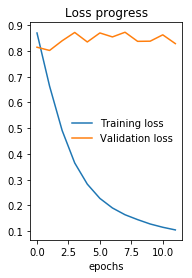

[INFO] 2019-04-05 17:21:46,607: Training completed in 11262 seconds
Min. valid loss: 0.8021301219463348
Last saved epoch: 1
Performance: 10 sentences/s


<Figure size 432x288 with 0 Axes>

In [8]:
regr.train(epochs=100, log_update_freq=25, patience=10)

In [9]:
regr.test(log_update_freq=25)

[INFO] 2019-04-05 17:21:46,612: Testing started.
[INFO] 2019-04-05 17:21:54,166: Test, batch nr. 31/125...
[INFO] 2019-04-05 17:21:58,361: Test, batch nr. 62/125...
[INFO] 2019-04-05 17:22:02,562: Test, batch nr. 93/125...
[INFO] 2019-04-05 17:22:06,898: Test, batch nr. 125/125...
[INFO] 2019-04-05 17:22:07,394: Testing completed in 21 seconds
Loss: 0.781833	 Pearson: (0.6039205079285322, 0.0)

